# Homework 2 - Programming Section Notebook

## Context

Given a dataset of 303 patients showcasing different medical metrics related to heart disease diagnostic, we must create a predictor for this diagnosis (target = 0 means no heart disease, whereas target = 1 means the a heart disease is present)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

dataset_file_path = "heart-disease.csv"

data_df = pd.read_csv(dataset_file_path)

X = data_df.drop("target", axis=1)
y = data_df["target"]

## 1) Compare kNN and naive Bayes

### a) Accuracy with no scaling before training

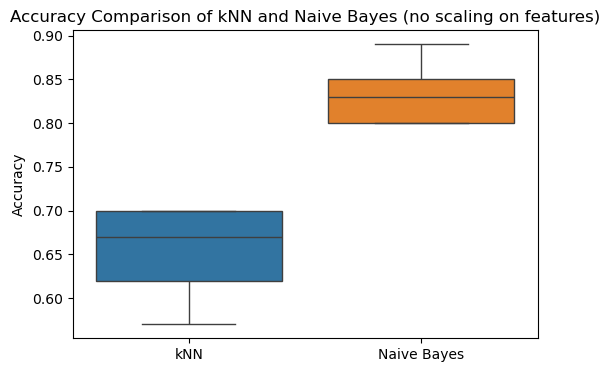

In [3]:
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import StratifiedKFold

n_splits = 5 
n_neighbors = 5

folds = StratifiedKFold(n_splits=n_splits,shuffle=True, random_state=0)

accuracy_kNN = []
accuracy_Bayes = []

for train_id, test_id in folds.split(X,y):

    #Extract Sample feature's matrix
    X_train = X.iloc[train_id]
    X_test = X.iloc[test_id]

    #Extract Sample's target matrix
    y_train = y.iloc[train_id]
    y_test = y.iloc[test_id]

    predictor_kNN = KNeighborsClassifier(n_neighbors=n_neighbors)
    predictor_kNN.fit(X_train, y_train)

    predictor_Bayes = GaussianNB()
    predictor_Bayes.fit(X_train,y_train)

    # Make prediction on testing sample for kNN
    y_pred_test_kNN = predictor_kNN.predict(X_test)
    accuracy_kNN.append(round(accuracy_score(y_test,y_pred_test_kNN), 2))

    # Make prediction on testing sample for naive Bayes
    y_pred_test_Bayes = predictor_Bayes.predict(X_test)
    accuracy_Bayes.append(round(accuracy_score(y_test, y_pred_test_Bayes), 2))

results_df = pd.DataFrame({
    'kNN': accuracy_kNN,
    'Naive Bayes': accuracy_Bayes
})

plt.figure(figsize=(6, 4))
sns.boxplot(data=results_df)
plt.title('Accuracy Comparison of kNN and Naive Bayes (no scaling on features)')
plt.ylabel('Accuracy')
plt.show()

### b) Accuracy with Min-Max scaler before training
Makes distant neighbours take less relevancy than close neighbours, scaling accordingly.

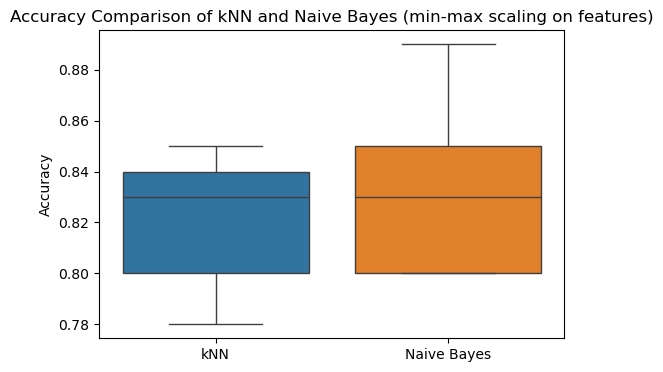

In [4]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X_scaled = pd.DataFrame(scaler.fit_transform(X, y), columns=X.columns) #Converted into pd df so the rest of the program can be mostly unchanged

n_splits = 5 
n_neighbors = 5

folds = StratifiedKFold(n_splits=n_splits,shuffle=True, random_state=0)

accuracy_kNN_scaling = []
accuracy_Bayes_scaling = []

for train_id, test_id in folds.split(X_scaled,y):

    #Extract Sample feature's matrix
    X_train = X_scaled.iloc[train_id]
    X_test = X_scaled.iloc[test_id]

    #Extract Sample's target matrix
    y_train = y.iloc[train_id]
    y_test = y.iloc[test_id]

    predictor_kNN = KNeighborsClassifier(n_neighbors=n_neighbors)
    predictor_kNN.fit(X_train, y_train)

    predictor_Bayes = GaussianNB()
    predictor_Bayes.fit(X_train,y_train)

    # Make prediction on testing sample for kNN
    y_pred_test_kNN = predictor_kNN.predict(X_test)
    accuracy_kNN_scaling.append(round(accuracy_score(y_test,y_pred_test_kNN), 2))

    # Make prediction on testing sample for naive Bayes
    y_pred_test_Bayes = predictor_Bayes.predict(X_test)
    accuracy_Bayes_scaling.append(round(accuracy_score(y_test, y_pred_test_Bayes), 2))

results_df_scaling = pd.DataFrame({
    'kNN': accuracy_kNN_scaling,
    'Naive Bayes': accuracy_Bayes_scaling
})

plt.figure(figsize=(6, 4))
sns.boxplot(data=results_df_scaling)
plt.title('Accuracy Comparison of kNN and Naive Bayes (min-max scaling on features)')
plt.ylabel('Accuracy')
plt.show()

### c) Test hypthosesis “the 𝑘𝑁𝑁 model is statistically superior to naïve Bayes regarding accuracy”

We will test the hypthosesis for both the feature-scaled and non-scaled versions

In [5]:
from scipy.stats import ttest_rel

# H0: both distributions have identical accuracy
# H1: kNN is statistically superior than Bayes in terms of accuracy

result_no_scale = ttest_rel(accuracy_kNN,accuracy_Bayes, alternative="greater")
results_scale = ttest_rel(accuracy_kNN_scaling,accuracy_Bayes_scaling,alternative="greater")

p_value_no_scale = result_no_scale.pvalue
print("No scale P-value: " + str(p_value_no_scale))
print("For the accuracies obtained when not scaling feature data:")
treshholds = (0.01, 0.05, 0.1)

for threshold in treshholds:
    if p_value_no_scale <= threshold:
        print("\t- Considering a " + str(int(threshold*100)) + "% threshold, kNN is statistically superior than Bayes")
    else:
        print("\t- Considering a " + str(int(threshold*100)) + "% threshold, kNN is not statistically superior than Bayes")

p_value_scale = results_scale.pvalue
print("\nScale P-value: " + str(p_value_scale))
print("For the accuracies obtained when min-max scaling feature data:")
for threshold in treshholds:
    if p_value_no_scale <= threshold:
        print("\t- Considering a " + str(int(threshold*100)) + "% threshold, kNN is statistically superior than Bayes")
    else:
        print("\t- Considering a " + str(int(threshold*100)) + "% threshold, kNN is not statistically superior than Bayes")


No scale P-value: 0.998415501126768
For the accuracies obtained when not scaling feature data:
	- Considering a 1% threshold, kNN is not statistically superior than Bayes
	- Considering a 5% threshold, kNN is not statistically superior than Bayes
	- Considering a 10% threshold, kNN is not statistically superior than Bayes

Scale P-value: 0.7532332545792753
For the accuracies obtained when min-max scaling feature data:
	- Considering a 1% threshold, kNN is not statistically superior than Bayes
	- Considering a 5% threshold, kNN is not statistically superior than Bayes
	- Considering a 10% threshold, kNN is not statistically superior than Bayes


## 2) Test kNN classifiers with different amount of k

### a) Train and Test accuracy for each k = {1, 5, 10, 20, 30}

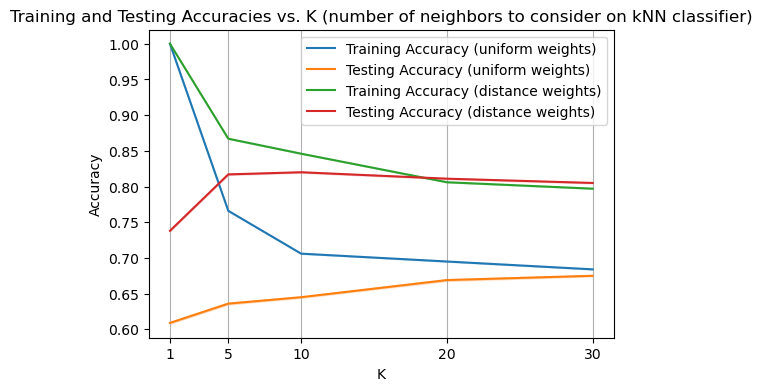

In [15]:
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X_scaled = pd.DataFrame(scaler.fit_transform(X, y), columns=X.columns) #Converted into pd df so the rest of the program can be mostly unchanged

number_of_neighbours = [1,5,10,20,30]

#FIXME - ASK IN CLASS ABOUT random_state in here!!!!
folds = StratifiedShuffleSplit(test_size=0.2, random_state=1)

training_accuracies_unscaled = []
testing_accuracies_unscaled = []

training_accuracies_scaled = []
testing_accuracies_scaled = []

for k in number_of_neighbours:
    training_sample_accuracy = []
    testing_sample_accuracy = []

    for train_id, test_id in folds.split(X,y):

        #Extract Sample feature's matrix
        X_train = X.iloc[train_id]
        X_test = X.iloc[test_id]

        #Extract Sample's outcomes matrix
        y_train = y.iloc[train_id]
        y_test = y.iloc[test_id]

        #Create kNN classifier according to sample training data
        predictor = KNeighborsClassifier(n_neighbors=k)
        predictor.fit(X_train,y_train)

        #Generate prediction according to test sample and measure accuracy
        y_pred_test = predictor.predict(X_test)
        testing_sample_accuracy.append(round(accuracy_score(y_test, y_pred_test),2))

        #Generate prediction according to training sample and measure accuracy
        y_pred_train = predictor.predict(X_train)
        training_sample_accuracy.append(round(accuracy_score(y_train, y_pred_train),2))
    
    #No need to calculate mean here, since seaborn does it on lineplot
    training_accuracies_unscaled.append(training_sample_accuracy) 
    testing_accuracies_unscaled.append(testing_sample_accuracy)

    training_sample_accuracy_scaled = []
    testing_sample_accuracy_scaled = []

    for train_id, test_id in folds.split(X_scaled,y):

        #Extract Sample feature's matrix
        X_train = X_scaled.iloc[train_id]
        X_test = X_scaled.iloc[test_id]

        #Extract Sample's outcomes matrix
        y_train = y.iloc[train_id]
        y_test = y.iloc[test_id]

        #Create kNN classifier according to sample training data
        predictor = KNeighborsClassifier(n_neighbors=k)
        predictor.fit(X_train,y_train)

        #Generate prediction according to test sample and measure accuracy
        y_pred_test = predictor.predict(X_test)
        testing_sample_accuracy_scaled.append(round(accuracy_score(y_test, y_pred_test),2))

        #Generate prediction according to training sample and measure accuracy
        y_pred_train = predictor.predict(X_train)
        training_sample_accuracy_scaled.append(round(accuracy_score(y_train, y_pred_train),2))
    
    #No need to calculate mean here, since seaborn does it on lineplot
    training_accuracies_scaled.append(training_sample_accuracy_scaled) 
    testing_accuracies_scaled.append(testing_sample_accuracy_scaled)

accuracy_df = pd.DataFrame({
    'k': number_of_neighbours,
    'training_accuracies_unscaled': training_accuracies_unscaled,
    'testing_accuracies_unscaled': testing_accuracies_unscaled,
    'training_accuracies_scaled': training_accuracies_scaled,
    'testing_accuracies_scaled': testing_accuracies_scaled
})

accuracy_df = accuracy_df.explode("training_accuracies_unscaled")
accuracy_df = accuracy_df.explode("testing_accuracies_unscaled")
accuracy_df = accuracy_df.explode("training_accuracies_scaled")
accuracy_df = accuracy_df.explode("testing_accuracies_scaled")

plt.figure(figsize=(6,4))
sns.lineplot(data=accuracy_df, x="k", y="training_accuracies_unscaled", label="Training Accuracy (uniform weights)")
sns.lineplot(data=accuracy_df, x="k", y="testing_accuracies_unscaled", label="Testing Accuracy (uniform weights)")
sns.lineplot(data=accuracy_df, x="k", y="training_accuracies_scaled", label="Training Accuracy (distance weights)")
sns.lineplot(data=accuracy_df, x="k", y="testing_accuracies_scaled", label="Testing Accuracy (distance weights)")
plt.xlabel("K")
plt.ylabel("Accuracy")
plt.title("Training and Testing Accuracies vs. K (number of neighbors to consider on kNN classifier)")
plt.legend()
plt.xticks(number_of_neighbours)
plt.grid(True, which='both', axis='x')
plt.show()

### b) Impact of neighbor increase on generalization capabilities of kNN classifiers

# RESPOSTA GPT PARA AJUDAR
Increasing the number of neighbors (\(k\)) in k-Nearest Neighbors (kNN) classifiers can significantly impact their generalization capabilities. Here are some key points to consider:

1. **Bias-Variance Tradeoff**: As \(k\) increases, the bias of the model typically increases while the variance decreases. This means the model becomes more stable and less sensitive to noise in the training data, but it might also become less flexible and potentially underfit the data¹.

2. **Smoothing Effect**: A larger \(k\) value results in a smoother decision boundary. This can be beneficial in noisy datasets as it reduces the risk of overfitting. However, if \(k\) is too large, the classifier might oversimplify the decision boundary, leading to underfitting².

3. **Computational Complexity**: Increasing \(k\) also increases the computational complexity, as the algorithm needs to compute distances to more neighbors. This can be particularly challenging in high-dimensional spaces³.

4. **Class Imbalance**: In datasets with imbalanced classes, a larger \(k\) might lead to a bias towards the majority class. This is because the majority class is more likely to dominate the \(k\) nearest neighbors².

5. **Optimal \(k\) Selection**: The optimal value of \(k\) often depends on the specific dataset and problem. Cross-validation is commonly used to determine the best \(k\) value by evaluating the model's performance on different subsets of the data⁴.

Would you like to dive deeper into any of these points or explore another aspect of kNN classifiers?

¹: [Enhancing K-nearest neighbor algorithm: a comprehensive review and performance analysis of modifications](https://journalofbigdata.springeropen.com/articles/10.1186/s40537-024-00973-y)
²: [A feature weighted K-nearest neighbor algorithm based on association rules](https://link.springer.com/article/10.1007/s12652-024-04793-z)
³: [k-Nearest Neighbors and High Dimensional Data](https://www.baeldung.com/cs/k-nearest-neighbors)
⁴: [On Convergence of Nearest Neighbor Classifiers over Feature Transformations](https://proceedings.neurips.cc/paper/2020/hash/93d9033636450402d67cd55e60b3f926-Abstract.html)

Source: Conversation with Copilot, 10/6/2024
(1) Enhancing K-nearest neighbor algorithm: a comprehensive review and .... https://journalofbigdata.springeropen.com/articles/10.1186/s40537-024-00973-y.
(2) A feature weighted K-nearest neighbor algorithm based on association .... https://link.springer.com/article/10.1007/s12652-024-04793-z.
(3) k-Nearest Neighbors and High Dimensional Data - Baeldung. https://www.baeldung.com/cs/k-nearest-neighbors.
(4) On Convergence of Nearest Neighbor Classifiers over Feature ... - NeurIPS. https://proceedings.neurips.cc/paper/2020/hash/93d9033636450402d67cd55e60b3f926-Abstract.html.
(5) An improved KNN classifier based on a novel weighted voting function .... https://link.springer.com/article/10.1007/s00521-023-09272-8.

## 3) Difficulties of naive Bayes on dataset

# RESPOSTA GPT PARA AJUDAR

Several dataset properties can significantly impact the performance of a Naive Bayes classifier:

1. **Feature Independence**: Naive Bayes assumes that all features are conditionally independent given the class label. If this assumption is violated, the classifier's performance can degrade¹.

2. **Class Imbalance**: If the dataset has an imbalanced class distribution, the classifier might be biased towards the majority class, leading to poor performance on the minority class².

3. **Feature Relevance**: Irrelevant or redundant features can negatively impact the classifier's performance. Feature selection or dimensionality reduction techniques can help mitigate this¹.

4. **Data Size**: The amount of training data can affect the classifier's performance. Generally, more data can lead to better performance, but the quality of the data is also crucial².

5. **Noise and Outliers**: Noisy data and outliers can mislead the classifier, resulting in poor performance. Preprocessing steps like data cleaning and outlier detection can help improve results¹.

6. **Data Distribution**: The distribution of the data can also impact performance. For example, if the data is not normally distributed, the Gaussian Naive Bayes variant might not perform well¹.

Would you like to dive deeper into any of these aspects or need help with something else?

Source: Conversation with Copilot, 10/6/2024
(1) How to Improve Naive Bayes Classification Performance?. https://www.baeldung.com/cs/naive-bayes-classification-performance.
(2) Part III: Naive Bayes for unbalanced datasets; why do all good things .... https://geronimo.ai/part-iii-naive-bayes-for-unbalanced-datasets-why-do-all-good-things-come-to-an-end/.
(3) Impact of Different Data Types on Classifier Performance of Random .... https://thesai.org/Publications/ViewPaper?Volume=8&Issue=12&Code=IJACSA&SerialNo=1.
(4) The Effects of Class Imbalance and Training Data Size on Classifier .... https://link.springer.com/article/10.1007/s42979-020-0074-0.
(5) Impact of Different Data Types on Classifier Performance of Random .... https://pdfs.semanticscholar.org/6952/da48af25d75e44665735e908b86cfe3e2d62.pdf.